## Monitoring and visualising model activation traces

In this notebook, we will use RL to train a network on a simple task, and we will visualise the activation traces of the neurons in the network.

### Task

We will use the [AnnubesEnv](https://github.com/neurogym/neurogym/blob/dev/neurogym/envs/annubes.py) environment for this demo. We set the duration of each trial period (fixation, stimulus, decision) and wrap the environment with a Monitor wrapper, which can be used to keep track of activation traces. After training, we can evaluate the agent and visualise the recorded traces. 

In [1]:
# Ignore warnings.
import warnings

warnings.filterwarnings("ignore")

from stable_baselines3.common.env_checker import check_env

from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO

from neurogym.envs.native.annubes import AnnubesEnv
from neurogym.wrappers.monitor import Monitor

In [2]:
# Time step duration in ms
dt = 10

env = AnnubesEnv(dt=dt)

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


Create a recurrent model and show the policy.

In [3]:
# Create the agent that will be trained in this environment
model = RecurrentPPO(
    RecurrentActorCriticPolicy, env, policy_kwargs={"lstm_hidden_size": 64, "recurrent_layer_type": "rnn"},
)

model.policy

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): RNN(4, 64)
  (lstm_critic): RNN(4, 64)
)

Get a reference to the action net from the policy. For now, it is referred to as `lstm_actor`, even though it is a vanilla RNN.

In [4]:
actor = model.policy.get_submodule("lstm_actor")

In [5]:
actor

RNN(4, 64)

Make sure that the time step is correctly registered

In [6]:
env.dt

10

### Train the agent

The agent can be trained on different environments. calls both the actor and the critic networks, so if the activations of the value net are needed, now is the opportunity to record them.

In [7]:
# Create an environment for evaluation
annubes_env = AnnubesEnv(dt=dt)

# Create a monitor
env = Monitor(env, name=f"NeuroGym Monitor | {annubes_env.__class__.__qualname__}")

Train the agent for a number of steps.

In [8]:
# Set the number timesteps for training
total_timesteps = 10000

# Train the agent.
model.learn(total_timesteps=total_timesteps)

Check out the shape of a single trace

Register the action net (a single layer in our case) with the monitor using the `record_activations()` method. The activations will be automatically extracted and stored after each step only for that layer. You can add as many layers as necessary in this way.

In [9]:
am = env.record_activations(actor, "Actor net")

Check the shapes of the neuron populations in this layer.

In [10]:
am.monitor.get_population_shapes()

{'output': (64,), 'hidden': (64,)}

Evaluate the agent over a number of trials

In [11]:
n_trials = 10

# Evaluate the policy
env.evaluate_policy(n_trials, model)

{'rewards': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'mean_reward': 1.0,
 'cum_rewards': [94.0,
  100.0,
  91.0,
  88.0,
  100.0,
  100.0,
  100.0,
  95.0,
  94.0,
  95.0],
 'mean_cum_reward': 95.7,
 'performances': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'mean_performance': 1.0}

Show the length of the history. Should be equal to the number of trials.

In [12]:
am.history["hidden"][0].shape

(150, 64)

Plot the activations in a separate panel for each neuron.

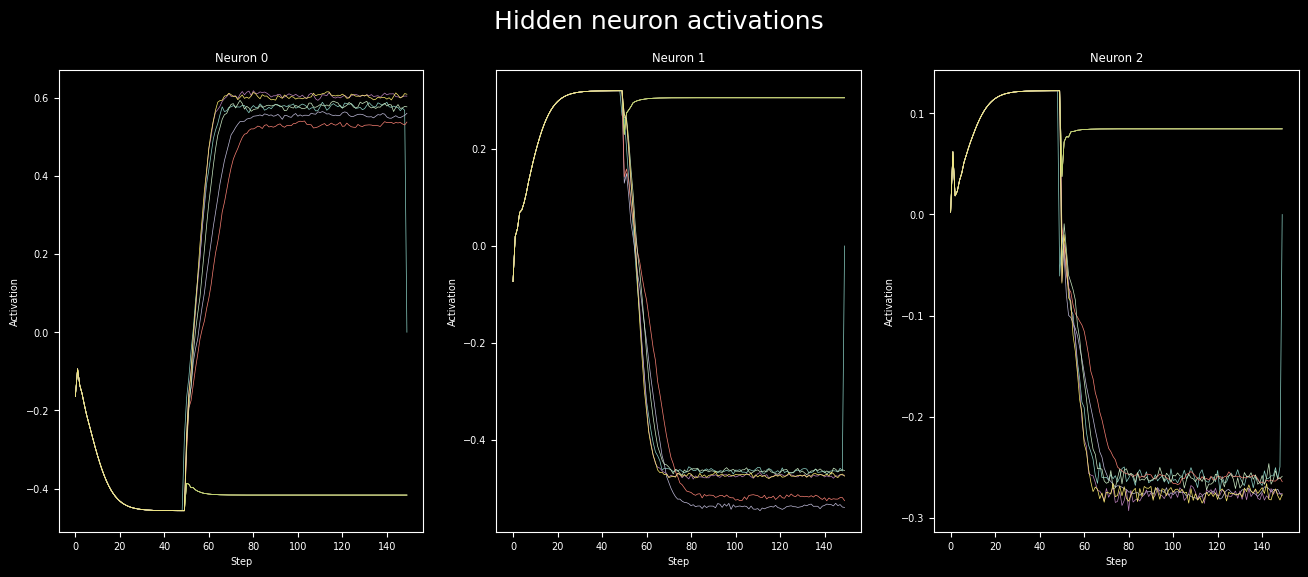

In [15]:
fig, axes = env.plot_activations(am.name, "hidden", neurons=[0,1,2])

We can also easily plot the __mean__ activations for each neuron.

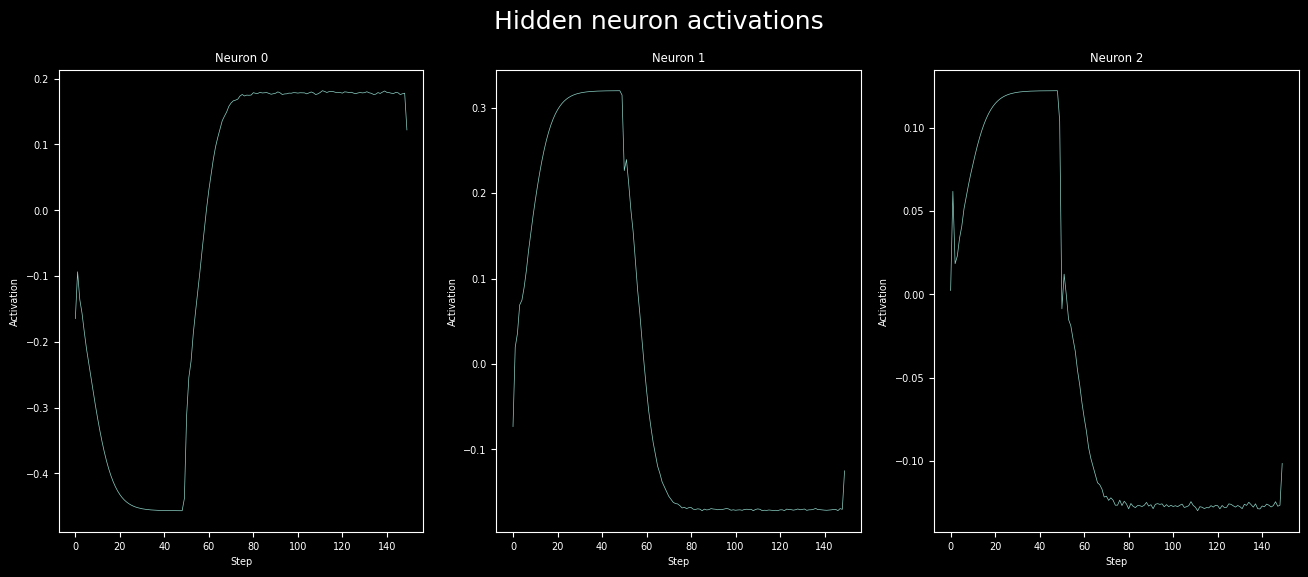

In [16]:
fig_mean, axes_mean = env.plot_activations(am.name, "hidden", neurons = [0,1,2], mean = True)